# Import Modules

In [44]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, r2_score, confusion_matrix, mean_squared_error

from scipy.stats import pearsonr

In [10]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_colwidth", None)

# Get Analysis Dataframe

### Load Clean Data 

In [4]:
# Load clean data
f1_races_clean = pd.read_csv("../data/final/f1_races_clean.csv", encoding="utf-8")
f1_races_clean.head()

,year,date,round,race,driver,driver_code,nationality,continent,team_name,points,pct_season_points,raw_end_position,end_position,position_status,start_position,place_differential,qualifying_time,time_gap,laps_completed,pit_count,fastest_lap,winner,winner_team_name,laps,total_time,race_url
0,1950,1950-05-13,1,Great Britain,Nino Farina,FAR,ITA,Europe,Alfa Romeo,9.0,0.055556,1,1.0,CLAS,1.0,0.0,1:50.800,2:13:23.600,70.0,NaN,1,Nino Farina,Alfa Romeo,70.0,2:13:23.600,https://www.formula1.com/en/results/1950/races/94/great-britain/race-result
1,1950,1950-05-13,1,Great Britain,Luigi Fagioli,FAG,ITA,Europe,Alfa Romeo,6.0,0.037037,2,2.0,CLAS,2.0,0.0,1:51.000,+2.600,70.0,NaN,0,Nino Farina,Alfa Romeo,70.0,2:13:23.600,https://www.formula1.com/en/results/1950/races/94/great-britain/race-result
2,1950,1950-05-13,1,Great Britain,Reg Parnell,PAR,GBR,Europe,Alfa Romeo,4.0,0.024691,3,3.0,CLAS,4.0,-1.0,1:52.200,+52.000,70.0,NaN,0,Nino Farina,Alfa Romeo,70.0,2:13:23.600,https://www.formula1.com/en/results/1950/races/94/great-britain/race-result
3,1950,1950-05-13,1,Great Britain,Yves Giraud-Cabantous,GIR,FRA,Europe,Talbot-Lago,3.0,0.018519,4,4.0,CLAS,6.0,-2.0,1:53.400,+2 laps,68.0,NaN,0,Nino Farina,Alfa Romeo,70.0,2:13:23.600,https://www.formula1.com/en/results/1950/races/94/great-britain/race-result
4,1950,1950-05-13,1,Great Britain,Louis Rosier,ROS,FRA,Europe,Talbot-Lago,2.0,0.012346,5,5.0,CLAS,9.0,-4.0,1:56.000,+2 laps,68.0,NaN,0,Nino Farina,Alfa Romeo,70.0,2:13:23.600,https://www.formula1.com/en/results/1950/races/94/great-britain/race-result


In [5]:
# Split shared car races into separate rows
shared_car_mask = f1_races_clean["driver"].str.contains('/', na=False)
shared_cars = f1_races_clean[shared_car_mask].copy()

# Create separate rows for each driver in shared cars
split_rows = []
for _, row in shared_cars.iterrows():
    drivers = row["driver"].split('/')
    driver_codes = row["driver_code"].split('/')
    for i in range(len(drivers)):
        new_row = row.copy()
        new_row["driver"] = drivers[i].strip()
        new_row["driver_code"] = driver_codes[i].strip()
        split_rows.append(new_row)

# Turn list into dataframe
split_rows_df = pd.DataFrame(split_rows)

# Combine with original data (excluding old shared car rows)
f1_races_clean = pd.concat([f1_races_clean[~shared_car_mask], split_rows_df], ignore_index=True)

In [6]:
# Load position data
drivers_info_with_pos = pd.read_csv("../data/intermediate/drivers_info_with_pos.csv", encoding="utf-8")

# Fix spacing issues in drivers names
drivers_info_with_pos["driver"] = drivers_info_with_pos["driver"].str.replace("  ", " ", regex=False)

# Merge
f1_races_clean = pd.merge(f1_races_clean, drivers_info_with_pos, on=["year", "driver"], how="left")

In [7]:
f1_races_clean.isna().sum()

year                      0
date                      0
round                     0
race                      0
driver                    0
driver_code               0
nationality            1594
continent              1594
team_name                 0
points                    0
pct_season_points         0
raw_end_position          0
end_position              0
position_status           0
start_position            0
place_differential        0
qualifying_time         525
time_gap               9922
laps_completed           84
pit_count             14292
fastest_lap               0
winner                    0
winner_team_name          0
laps                      0
total_time                0
race_url                  0
season_rank            4276
dtype: int64

### Select Features

In [8]:
f1_stats = f1_races_clean[["year", "driver", "continent", "team_name", "season_rank", "points", "pct_season_points", "start_position", "end_position", "place_differential", "position_status", "laps_completed", "laps", "fastest_lap"]].copy()

### Select Statistics

In [9]:
# One-hot encode position_status
position_status_OHE = pd.get_dummies(f1_stats["position_status"])
f1_stats = pd.concat([f1_stats, position_status_OHE], axis=1)
f1_stats = f1_stats.drop("position_status", axis=1)

# Remove rows with privateer teams
f1_stats = f1_stats[(f1_stats["team_name"] != "Privateer")]

# Calculate yearly statistics for each driver
f1_analysis = f1_stats.groupby(["year", "driver", "team_name"]).agg({
    "continent": "first",
    "season_rank": "first",
    "start_position": ["mean", "std", "min", "max", "count"],  # Count gives races participated
    "end_position": ["mean", "std", "min", "max"],
    "place_differential": ["sum", "mean"],
    "points": ["sum", "mean"],
    "pct_season_points": ["sum", "mean", "min", "max"],
    "laps_completed": "sum",
    "laps": "sum",
    "fastest_lap": "sum",
    "CLAS": "sum",
    "DNF": "sum",
    "DNS": "sum",
    "DQ": "sum",
    "NC": "sum"
}).reset_index()

# Flatten column names
f1_analysis.columns = [
    "year", "driver", "team_name", 
    "continent",
    "season_rank",
    "avg_start_pos", "std_start_pos", "best_start_pos", "worst_start_pos", "races_participated",
    "avg_finish_pos", "std_finish_pos", "best_finish_pos", "worst_finish_pos",
    "total_pos_gain", "avg_pos_gain",
    "total_points", "avg_points_per_race",
    "total_pct_season_points", "avg_pct_season_points", "worst_pct_season_points", "best_pct_season_points",
    "total_laps_completed",
    "total_laps",
    "total_fastest_laps",
    "CLAS_total",
    "DNF_total",
    "DNS_total",
    "DQ_total",
    "NC_total"
]

# Create new driver status column
def get_driver_status(row):
    if row["avg_finish_pos"] <= 3:
        return "podium_regular"
    elif row["avg_finish_pos"] <= 10:
        return "points_regular" 
    elif row["avg_finish_pos"] <= 15:
        return "midfield"
    else:
        return "backmarker"

f1_analysis["driver_status"] = f1_analysis.apply(get_driver_status, axis=1)

# One-hot encode driver_status
driver_status_OHE = pd.get_dummies(f1_analysis["driver_status"])
f1_analysis = pd.concat([f1_analysis, driver_status_OHE], axis=1)
f1_analysis = f1_analysis.drop("driver_status", axis=1)

# Sort by year then season rank
f1_analysis = f1_analysis.sort_values(["year", "season_rank"])

f1_analysis.head()

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular
58,1950,Nino Farina,Alfa Romeo,Europe,1,1.833333,0.752773,1.0,3.0,6,4.333333,4.457204,1.0,12.0,15.0,2.500000,30.0,5.0,0.185185,0.030864,0.000000,0.055556,282.0,391.0,3,5,0,0,0,1,False,False,False,True
8,1950,Cecil Green,Kurtis Kraft,North America,13,12.000000,NaN,12.0,12.0,1,4.000000,NaN,4.0,4.0,-8.0,-8.000000,3.0,3.0,0.018519,0.018519,0.018519,0.018519,137.0,138.0,0,1,0,0,0,0,False,False,False,True
16,1950,Dorino Serafini,Ferrari,Europe,13,6.000000,NaN,6.0,6.0,1,2.000000,NaN,2.0,2.0,-4.0,-4.000000,3.0,3.0,0.018519,0.018519,0.018519,0.018519,80.0,80.0,0,1,0,0,0,0,False,False,True,False
64,1950,Philippe Etancelin,Talbot-Lago,Europe,13,8.500000,5.205766,4.0,16.0,6,8.833333,3.600926,5.0,13.0,2.0,0.333333,3.0,0.5,0.018519,0.003086,0.000000,0.012346,275.0,391.0,0,3,0,0,0,3,False,False,False,True
68,1950,Raymond Sommer,Ferrari,Europe,13,11.000000,2.828427,9.0,13.0,2,9.000000,7.071068,4.0,14.0,-4.0,-2.000000,3.0,1.5,0.018519,0.009259,0.000000,0.018519,116.0,142.0,0,1,0,0,0,1,False,False,False,True


### Data Cleaning

In [10]:
# Impute missing season ranks

# Convert DQ values to None
f1_analysis["season_rank"] = f1_analysis["season_rank"].replace("DQ", None)

# Convert season_rank to numeric
f1_analysis["season_rank"] = pd.to_numeric(f1_analysis["season_rank"], errors="coerce")

# Get max rank per year for drivers with ranks
max_ranks = f1_analysis.groupby("year")["season_rank"].max().reset_index()
max_ranks.columns = ["year", "max_rank"]

# Merge back to original df
f1_analysis = f1_analysis.merge(max_ranks, on="year", how="left")

# For drivers with no rank, calculate their rank starting from max_rank + 1
null_mask = f1_analysis["season_rank"].isna()
f1_analysis.loc[null_mask, "season_rank"] = (
    f1_analysis[null_mask]
    .sort_values(["total_points", "best_finish_pos", "races_participated", "total_fastest_laps", "driver"], ascending=[False, True, False, False, True])
    .groupby("year")
    .cumcount() + 1 + f1_analysis[null_mask]["max_rank"]
)

# Drop extra column
f1_analysis = f1_analysis.drop("max_rank", axis=1)

# Convert season_rank to integer type
f1_analysis["season_rank"] = f1_analysis["season_rank"].astype(int)

# Sort by year then season rank
f1_analysis = f1_analysis.sort_values(["year", "season_rank"])

In [11]:
# Fill null values in std_start_pos and std_finish_pos with 0
f1_analysis["std_start_pos"] = f1_analysis["std_start_pos"].fillna(0)
f1_analysis["std_finish_pos"] = f1_analysis["std_finish_pos"].fillna(0)

In [12]:
f1_analysis.head(30)

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular
0,1950,Nino Farina,Alfa Romeo,Europe,1,1.833333,0.752773,1.0,3.0,6,4.333333,4.457204,1.0,12.0,15.0,2.500000,30.0,5.000000,0.185185,0.030864,0.000000,0.055556,282.0,391.0,3,5,0,0,0,1,False,False,False,True
9,1950,Juan Manuel Fangio,Alfa Romeo,South America,2,2.500000,2.345208,1.0,7.0,6,6.666667,6.218253,1.0,13.0,25.0,4.166667,26.0,4.333333,0.160494,0.026749,0.000000,0.055556,328.0,391.0,2,3,0,0,0,3,False,False,False,True
13,1950,Luigi Fagioli,Alfa Romeo,Europe,3,3.500000,1.224745,2.0,5.0,6,3.666667,3.614784,2.0,11.0,1.0,0.166667,28.0,4.666667,0.172840,0.028807,0.000000,0.037037,291.0,391.0,0,5,0,0,0,1,False,False,False,True
14,1950,Louis Rosier,Talbot-Lago,Europe,4,11.000000,2.966479,8.0,16.0,6,5.666667,3.777124,3.0,13.0,-32.0,-5.333333,13.0,2.166667,0.080247,0.013374,0.000000,0.024691,275.0,391.0,0,5,0,0,0,1,False,False,False,True
15,1950,Alberto Ascari,Ferrari,Europe,5,6.000000,0.816497,5.0,7.0,4,6.500000,7.141428,2.0,17.0,2.0,0.500000,11.0,2.750000,0.067901,0.016975,0.000000,0.037037,217.0,257.0,0,3,0,0,0,1,False,False,False,True
16,1950,Johnnie Parsons,Kurtis Kraft,North America,6,5.000000,0.000000,5.0,5.0,1,1.000000,0.000000,1.0,1.0,-4.0,-4.000000,9.0,9.000000,0.055556,0.055556,0.055556,0.055556,138.0,138.0,1,1,0,0,0,0,False,False,True,False
17,1950,Bill Holland,Deidt,North America,7,10.000000,0.000000,10.0,10.0,1,2.000000,0.000000,2.0,2.0,-8.0,-8.000000,6.0,6.000000,0.037037,0.037037,0.037037,0.037037,137.0,138.0,0,1,0,0,0,0,False,False,True,False
18,1950,Prince Bira,Maserati,Asia,8,10.750000,5.057997,5.0,15.0,4,12.250000,10.210289,4.0,26.0,6.0,1.500000,5.0,1.250000,0.030864,0.007716,0.000000,0.018519,185.0,292.0,0,2,0,0,0,2,False,True,False,False
19,1950,Louis Chiron,Maserati,Europe,9,13.600000,4.277850,8.0,19.0,5,13.400000,7.503333,3.0,22.0,-1.0,-0.200000,4.0,0.800000,0.024691,0.004938,0.000000,0.024691,181.0,356.0,0,2,0,0,0,3,False,True,False,False
20,1950,Mauri Rose,Deidt,North America,9,3.000000,0.000000,3.0,3.0,1,3.000000,0.000000,3.0,3.0,0.0,0.000000,4.0,4.000000,0.024691,0.024691,0.024691,0.024691,137.0,138.0,0,1,0,0,0,0,False,False,True,False


### Feature Engineering

In [13]:
# Years experience
f1_analysis["years_experience"] = f1_analysis.groupby("driver")["year"].rank(method="dense")

# Podium and points finishes per season
podium_counts = f1_races_clean[f1_races_clean["end_position"] <= 3].groupby(["driver", "year", "team_name"]).size().reset_index(name="total_podium_finishes")
points_counts = f1_races_clean[f1_races_clean["end_position"] <= 10].groupby(["driver", "year", "team_name"]).size().reset_index(name="total_points_finishes")
f1_analysis = f1_analysis.merge(podium_counts, on=["driver", "year", "team_name"], how="left")
f1_analysis = f1_analysis.merge(points_counts, on=["driver", "year", "team_name"], how="left")
f1_analysis["total_podium_finishes"] = f1_analysis["total_podium_finishes"].fillna(0).astype(int)
f1_analysis["total_points_finishes"] = f1_analysis["total_points_finishes"].fillna(0).astype(int)

# DNF and reliability metrics
f1_analysis["dnf_rate"] = (f1_analysis["DNF_total"] + f1_analysis["DQ_total"] + f1_analysis["NC_total"]) / f1_analysis["races_participated"]
f1_analysis["finish_rate"] = f1_analysis["CLAS_total"] / f1_analysis["races_participated"]
f1_analysis["lap_completion_rate"] = f1_analysis["total_laps_completed"] / f1_analysis["total_laps"]
f1_analysis["fastest_lap_rate"] = f1_analysis["total_fastest_laps"] / f1_analysis["races_participated"]

# Performance consistency metrics
f1_analysis["podium_rate"] = f1_analysis["total_podium_finishes"] / f1_analysis["races_participated"] 
f1_analysis["points_rate"] = f1_analysis["total_points_finishes"] / f1_analysis["races_participated"]
f1_analysis["consistency_score"] = 1 - (f1_analysis["std_finish_pos"] / f1_analysis["avg_finish_pos"])
f1_analysis["qualifying_consistency"] = 1 - (f1_analysis["std_start_pos"] / f1_analysis["avg_start_pos"])
f1_analysis["reliability_score"] = f1_analysis["finish_rate"] * f1_analysis["lap_completion_rate"]

# Race pace and overtaking metrics
f1_analysis["qualifying_vs_race"] = f1_analysis["avg_finish_pos"] - f1_analysis["avg_start_pos"]
f1_analysis["championship_impact"] = f1_analysis["avg_pct_season_points"] * f1_analysis["finish_rate"]
f1_analysis["race_improvement"] = f1_analysis["avg_pos_gain"] / f1_analysis["avg_start_pos"]

### Create Label

In [14]:
# Create mapping of driver-team pairs by year
driver_team_mapping = f1_analysis[["year", "driver", "team_name"]].drop_duplicates()

# Get next years team for each driver
driver_team_mapping["next_year"] = driver_team_mapping["year"] + 1
driver_team_mapping["next_team"] = driver_team_mapping.groupby("driver")["team_name"].shift(-1)

# Merge back to original dataframe
f1_analysis = f1_analysis.merge(driver_team_mapping[["year", "driver", "next_team"]], on=["year", "driver"], how="left")

# Create binary column (1 if same team next year, 0 otherwise)
f1_analysis["driver_retained"] = ((f1_analysis["team_name"] == f1_analysis["next_team"]).astype(int))

# Manually set 2024
retention_2024 = [
    {"driver": "Max Verstappen", "team_name": "Red Bull", "year": 2024, "driver_retained": 1},
    {"driver": "Lando Norris", "team_name": "McLaren", "year": 2024, "driver_retained": 1},
    {"driver": "Charles Leclerc", "team_name": "Ferrari", "year": 2024, "driver_retained": 1},
    {"driver": "Oscar Piastri", "team_name": "McLaren", "year": 2024, "driver_retained": 1},
    {"driver": "Carlos Sainz", "team_name": "Ferrari", "year": 2024, "driver_retained": 0},
    {"driver": "George Russell", "team_name": "Mercedes", "year": 2024, "driver_retained": 1},
    {"driver": "Lewis Hamilton", "team_name": "Mercedes", "year": 2024, "driver_retained": 0},
    {"driver": "Sergio Perez", "team_name": "Red Bull", "year": 2024, "driver_retained": 0},
    {"driver": "Fernando Alonso", "team_name": "Aston Martin", "year": 2024, "driver_retained": 1},
    {"driver": "Pierre Gasly", "team_name": "Alpine", "year": 2024, "driver_retained": 1},
    {"driver": "Nico Hulkenberg", "team_name": "Haas", "year": 2024, "driver_retained": 0},
    {"driver": "Yuki Tsunoda", "team_name": "Racing Bulls", "year": 2024, "driver_retained": 0},
    {"driver": "Lance Stroll", "team_name": "Aston Martin", "year": 2024, "driver_retained": 1},
    {"driver": "Esteban Ocon", "team_name": "Alpine", "year": 2024, "driver_retained": 0},
    {"driver": "Kevin Magnussen", "team_name": "Haas", "year": 2024, "driver_retained": 0},
    {"driver": "Alexander Albon", "team_name": "Williams", "year": 2024, "driver_retained": 1},
    {"driver": "Daniel Ricciardo", "team_name": "Racing Bulls", "year": 2024, "driver_retained": 0},
    {"driver": "Oliver Bearman", "team_name": "Ferrari", "year": 2024, "driver_retained": 0},
    {"driver": "Oliver Bearman", "team_name": "Haas", "year": 2024, "driver_retained": 1},
    {"driver": "Franco Colapinto", "team_name": "Williams", "year": 2024, "driver_retained": 0},
    {"driver": "Zhou Guanyu", "team_name": "Sauber", "year": 2024, "driver_retained": 0},
    {"driver": "Liam Lawson", "team_name": "Racing Bulls", "year": 2024, "driver_retained": 1},
    {"driver": "Valtteri Bottas", "team_name": "Sauber", "year": 2024, "driver_retained": 0},
    {"driver": "Logan Sargeant", "team_name": "Williams", "year": 2024, "driver_retained": 0},
    {"driver": "Jack Doohan", "team_name": "Alpine", "year": 2024, "driver_retained": 1},
]

# Merge 2024 retention data into f1_analysis
retention_2024_df = pd.DataFrame(retention_2024)
f1_analysis = f1_analysis.merge(retention_2024_df[["year", "driver", "team_name", "driver_retained"]], on=["year", "driver", "team_name"], how="left", suffixes=("", "_new"))

# Update driver_retained column with new values where available
f1_analysis["driver_retained"] = f1_analysis["driver_retained_new"].fillna(f1_analysis["driver_retained"])
f1_analysis["driver_retained"] = f1_analysis["driver_retained"].astype(int)

# Clean up temporary columns
f1_analysis.drop(columns=["driver_retained_new"], inplace=True)
f1_analysis.drop(columns=["next_team"], inplace=True)
f1_analysis.drop_duplicates(inplace=True)

In [15]:
# Convert columns to ints
columns_to_convert = ["best_start_pos", "worst_start_pos", "best_finish_pos", "worst_finish_pos", "total_pos_gain", "total_laps_completed", "total_laps", "years_experience"]
for col in columns_to_convert:
    f1_analysis[col] = f1_analysis[col].astype(int)

In [16]:
f1_analysis[f1_analysis['year'] == 2023]

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular,years_experience,total_podium_finishes,total_points_finishes,dnf_rate,finish_rate,lap_completion_rate,fastest_lap_rate,podium_rate,points_rate,consistency_score,qualifying_consistency,reliability_score,qualifying_vs_race,championship_impact,race_improvement,driver_retained
3720,2023,Max Verstappen,Red Bull,Europe,1,3.181818,3.862350,1,15,22,1.272727,0.882735,1,5,-42,-1.909091,511.0,23.227273,0.238117,0.010824,0.0,0.012116,1325,1325,9,22,0,0,0,0,False,False,True,False,9,21,22,0.000000,1.000000,1.000000,0.409091,0.954545,1.000000,0.306423,-0.213881,1.000000,-1.909091,0.010824,-0.600000,1
3721,2023,Sergio Perez,Red Bull,North America,2,9.227273,6.015312,1,20,22,5.863636,5.548878,1,20,-74,-3.363636,248.0,11.272727,0.115564,0.005253,0.0,0.011650,1215,1325,2,20,0,0,0,2,False,False,False,True,13,9,19,0.090909,0.909091,0.916981,0.090909,0.409091,0.863636,0.053680,0.348094,0.833619,-3.363636,0.004775,-0.364532,1
3722,2023,Lewis Hamilton,Mercedes,Europe,3,6.090909,3.279214,1,13,22,5.409091,3.685998,2,19,-15,-0.681818,217.0,9.863636,0.101118,0.004596,0.0,0.008854,1268,1325,4,20,0,0,1,1,False,False,False,True,17,7,21,0.090909,0.909091,0.956981,0.181818,0.318182,0.954545,0.318555,0.461622,0.869983,-0.681818,0.004178,-0.111940,1
3723,2023,Fernando Alonso,Aston Martin,Europe,4,6.909091,4.069738,2,19,22,6.636364,4.624422,2,18,-6,-0.272727,198.0,9.000000,0.092265,0.004194,0.0,0.008854,1294,1325,1,20,0,0,0,2,False,False,False,True,20,8,19,0.090909,0.909091,0.976604,0.045455,0.363636,0.863636,0.303169,0.410959,0.887822,-0.272727,0.003813,-0.039474,1
3724,2023,Charles Leclerc,Ferrari,Europe,5,4.954545,4.455893,1,19,22,7.545455,6.200824,2,20,57,2.590909,185.0,8.409091,0.086207,0.003918,0.0,0.008388,1147,1325,0,17,0,0,1,4,False,False,False,True,6,6,17,0.227273,0.772727,0.865660,0.000000,0.272727,0.772727,0.178204,0.100646,0.668919,2.590909,0.003028,0.522936,1
3725,2023,Lando Norris,McLaren,Europe,6,7.954545,5.295796,2,19,22,8.000000,6.078847,2,20,1,0.045455,166.0,7.545455,0.077353,0.003516,0.0,0.008854,1273,1325,1,21,0,0,0,1,False,False,False,True,5,7,16,0.045455,0.954545,0.960755,0.045455,0.318182,0.727273,0.240144,0.334243,0.917084,0.045455,0.003356,0.005714,1
3726,2023,Carlos Sainz,Ferrari,Europe,7,5.772727,4.070004,1,16,22,7.500000,5.234956,1,20,38,1.727273,163.0,7.409091,0.075955,0.003453,0.0,0.011650,1246,1325,0,20,0,0,0,2,False,False,False,True,9,3,18,0.090909,0.909091,0.940377,0.000000,0.136364,0.818182,0.302006,0.294960,0.854889,1.727273,0.003139,0.299213,1
3727,2023,George Russell,Mercedes,Europe,8,6.454545,3.984820,2,18,22,8.090909,5.181552,3,19,36,1.636364,147.0,6.681818,0.068500,0.003114,0.0,0.006990,1252,1325,1,19,0,0,0,3,False,False,False,True,5,2,17,0.136364,0.863636,0.944906,0.045455,0.090909,0.772727,0.359583,0.382634,0.816055,1.636364,0.002689,0.253521,1
3728,2023,Oscar Piastri,McLaren,Oceania,9,9.636364,5.214864,2,19,22,10.909091,5.397611,2,20,28,1.272727,82.0,3.727273,0.038211,0.001737,0.0,0.008388,1185,1325,2,19,0,0,0,3,False,True,False,False,1,2,11,0.136364,0.863636,0.894340,0.090909,0.090909,0.500000,0.505219,0.458835,0.772384,1.272727,0.001500,0.132075,1
3729,2023,Lance Stroll,Aston Martin,North America,10,12.818182,5.662209,3,20,22,11.181818,5.252087,4,20,-36,-1.636364,62.0,2.818182,0.028891,0.001313,0.0,0.005592,1165,1325,0,18,1,0,0,3,False,True,False,False,7,0,12,0.181818,0.818182,0.879245,0.000000,0.000000,0.545455,0.530301,0.558267,0.719383,-1.636364,0.001074,-0.127660,1


### Save Analysis Dataframe

In [17]:
f1_analysis.to_csv("../data/final/f1_final.csv", encoding="utf-8", index=False)

# Driver Retention Analysis (1950-2024)

*Gradient Boosting the best model with accuracy of 0.6566 and F1 of 0.4968*

### Load Data

In [18]:
f1_final = pd.read_csv("../data/final/f1_final.csv", encoding="utf-8")
f1_final.head(3)

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular,years_experience,total_podium_finishes,total_points_finishes,dnf_rate,finish_rate,lap_completion_rate,fastest_lap_rate,podium_rate,points_rate,consistency_score,qualifying_consistency,reliability_score,qualifying_vs_race,championship_impact,race_improvement,driver_retained
0,1950,Nino Farina,Alfa Romeo,Europe,1,1.833333,0.752773,1,3,6,4.333333,4.457204,1,12,15,2.500000,30.0,5.000000,0.185185,0.030864,0.0,0.055556,282,391,3,5,0,0,0,1,False,False,False,True,1,3,5,0.166667,0.833333,0.721228,0.500000,0.500000,0.833333,-0.028586,0.589397,0.601023,2.500000,0.025720,1.363636,1
1,1950,Juan Manuel Fangio,Alfa Romeo,South America,2,2.500000,2.345208,1,7,6,6.666667,6.218253,1,13,25,4.166667,26.0,4.333333,0.160494,0.026749,0.0,0.055556,328,391,2,3,0,0,0,3,False,False,False,True,1,3,3,0.500000,0.500000,0.838875,0.333333,0.500000,0.500000,0.067262,0.061917,0.419437,4.166667,0.013374,1.666667,1
2,1950,Luigi Fagioli,Alfa Romeo,Europe,3,3.500000,1.224745,2,5,6,3.666667,3.614784,2,11,1,0.166667,28.0,4.666667,0.172840,0.028807,0.0,0.037037,291,391,0,5,0,0,0,1,False,False,False,True,1,5,5,0.166667,0.833333,0.744246,0.000000,0.833333,0.833333,0.014150,0.650073,0.620205,0.166667,0.024005,0.047619,1


### Split Data

In [19]:
# Set X and y variables
X = f1_final.drop(columns=["driver_retained", "year", "driver", "team_name", "continent", "total_points", "avg_points_per_race", "total_laps_completed", "total_laps"]).values
y = f1_final["driver_retained"].values

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Model

In [20]:
# Random Forest
rf = RandomForestClassifier(random_state=42)

# Fit data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Results
print(f"Accuracy: {rf.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5997150997150997
F1: 0.46880907372400754
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       412
           1       0.52      0.43      0.47       290

    accuracy                           0.60       702
   macro avg       0.58      0.57      0.57       702
weighted avg       0.59      0.60      0.59       702



### Decision Tree Model

In [21]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Fit data
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Results
print(f"Accuracy: {dt.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.5270655270655271
F1: 0.4334470989761092
              precision    recall  f1-score   support

           0       0.60      0.59      0.59       412
           1       0.43      0.44      0.43       290

    accuracy                           0.53       702
   macro avg       0.51      0.51      0.51       702
weighted avg       0.53      0.53      0.53       702



### Logistic Regression Model

In [22]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=2000)

# Fit data
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Results
print(f"Accuracy: {log_reg.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6581196581196581
F1: 0.4759825327510917
              precision    recall  f1-score   support

           0       0.66      0.86      0.75       412
           1       0.65      0.38      0.48       290

    accuracy                           0.66       702
   macro avg       0.65      0.62      0.61       702
weighted avg       0.66      0.66      0.63       702



### Gradient Boosting Model

In [23]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# Fit data
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

# Results
print(f"Accuracy: {gb.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6566951566951567
F1: 0.4968684759916493
              precision    recall  f1-score   support

           0       0.67      0.83      0.74       412
           1       0.63      0.41      0.50       290

    accuracy                           0.66       702
   macro avg       0.65      0.62      0.62       702
weighted avg       0.65      0.66      0.64       702



### Point Inflation

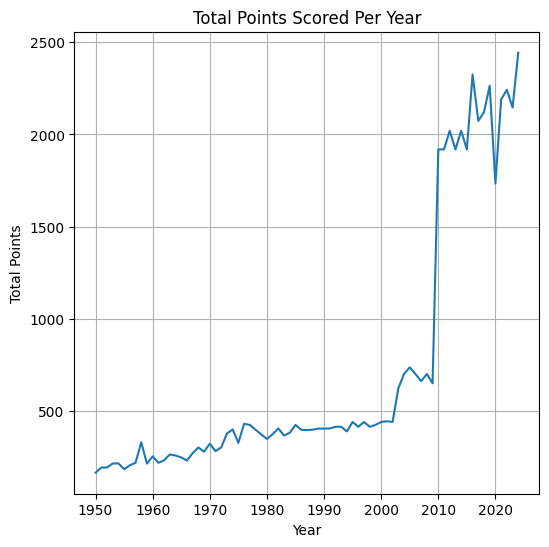

In [24]:
# Add total aggregate points line chart
yearly_points = f1_final.groupby(["year"])["total_points"].sum().reset_index()

plt.figure(figsize=(6, 6))
plt.plot(yearly_points["year"], yearly_points["total_points"])
plt.title("Total Points Scored Per Year")
plt.xlabel("Year")
plt.ylabel("Total Points")
plt.grid(True)
plt.show()

*Massive point inflation in 2010. So will try models again using 2010-2024 and including points data*

# Driver Retention Analysis (2010-2024)

*Random Forest the best model with accuracy of 0.7671 and F1 of 0.8045*

### Load Data

In [25]:
f1_final = pd.read_csv("../data/final/f1_final.csv", encoding="utf-8")
f1_final_2010 = f1_final[f1_final["year"] >= 2010]
f1_final_2010.head(3)

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular,years_experience,total_podium_finishes,total_points_finishes,dnf_rate,finish_rate,lap_completion_rate,fastest_lap_rate,podium_rate,points_rate,consistency_score,qualifying_consistency,reliability_score,qualifying_vs_race,championship_impact,race_improvement,driver_retained
3146,2010,Sebastian Vettel,Red Bull,Europe,1,1.947368,1.352926,1,6,19,6.000000,6.565905,1,22,77,4.052632,256.0,13.473684,0.133403,0.007021,0.0,0.013028,1066,1129,3,16,0,0,0,3,False,False,False,True,4,10,15,0.157895,0.842105,0.944198,0.157895,0.526316,0.789474,-0.094318,0.305254,0.795114,4.052632,0.005913,2.081081,1
3147,2010,Fernando Alonso,Ferrari,Europe,2,5.789474,6.214490,1,24,19,5.421053,5.439728,1,21,-7,-0.368421,252.0,13.263158,0.131318,0.006911,0.0,0.013028,1120,1129,5,18,0,0,0,1,False,False,False,True,9,10,16,0.052632,0.947368,0.992028,0.263158,0.526316,0.842105,-0.003445,-0.073412,0.939816,-0.368421,0.006548,-0.063636,1
3148,2010,Mark Webber,Red Bull,Oceania,3,2.789474,1.843274,1,7,19,6.052632,6.736911,1,24,62,3.263158,242.0,12.736842,0.126107,0.006637,0.0,0.013028,1043,1129,3,17,0,0,0,2,False,False,False,True,9,10,17,0.105263,0.894737,0.923826,0.157895,0.526316,0.894737,-0.113055,0.339203,0.826582,3.263158,0.005939,1.169811,1


### Split Data

In [26]:
# Set X and y variables
X = f1_final_2010.drop(columns=["driver_retained", "year", "driver", "team_name", "continent", "total_laps_completed", "total_laps"]).values
y = f1_final_2010["driver_retained"].values

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Random Forest Model

In [27]:
# Random Forest
rf = RandomForestClassifier(random_state=42)

# Fit data
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Results
print(f"Accuracy: {rf.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.7671232876712328
F1: 0.8045977011494253
              precision    recall  f1-score   support

           0       0.88      0.60      0.71        35
           1       0.71      0.92      0.80        38

    accuracy                           0.77        73
   macro avg       0.79      0.76      0.76        73
weighted avg       0.79      0.77      0.76        73



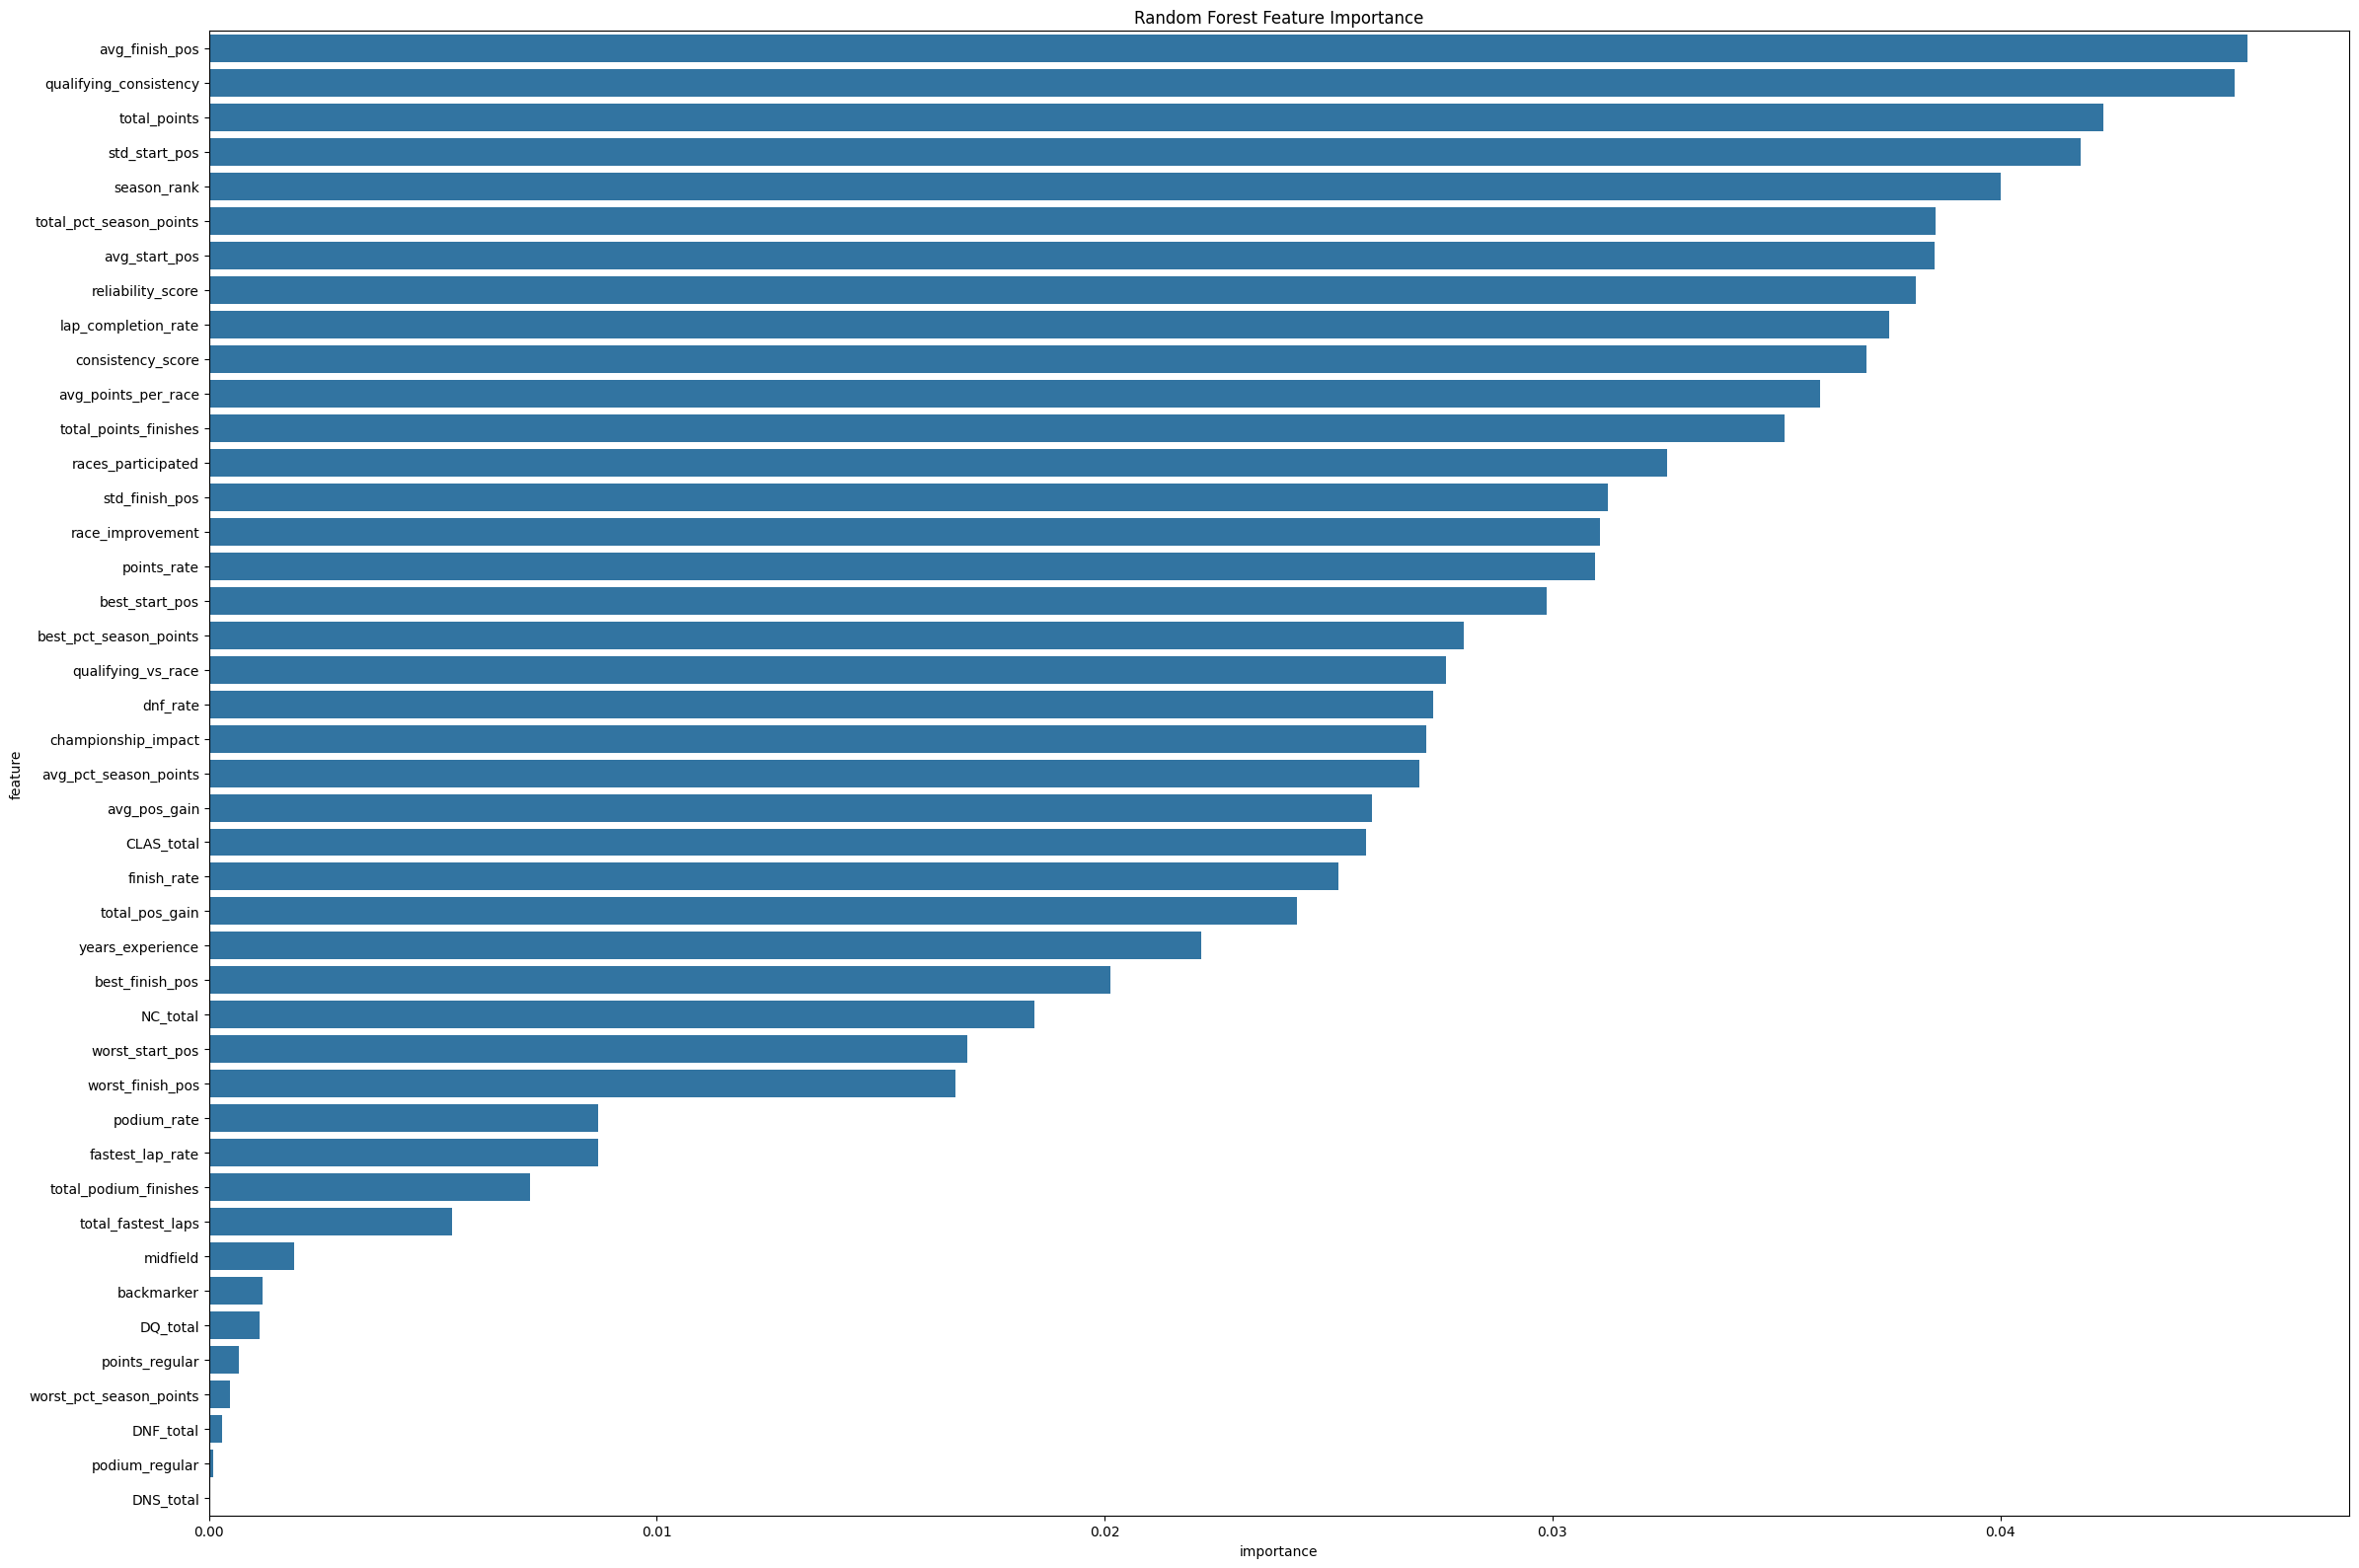

'Top 10 Most Important Features:'

,feature,importance
6,avg_finish_pos,0.045516
38,qualifying_consistency,0.045234
12,total_points,0.042304
2,std_start_pos,0.041801
0,season_rank,0.040010
14,total_pct_season_points,0.038554
1,avg_start_pos,0.038544
39,reliability_score,0.038123
33,lap_completion_rate,0.037511
37,consistency_score,0.037010


In [28]:
# Get feature importances
importances = rf.feature_importances_
feature_names = f1_final_2010.drop(columns=["driver_retained", "year", "driver", "team_name", "continent", "total_laps_completed", "total_laps"]).columns

# Create dataframe of feature importances
feature_importances = pd.DataFrame({"feature": feature_names, "importance": importances})

# Sort by importance
feature_importances = feature_importances.sort_values("importance", ascending=False)

# Plot feature importances
plt.figure(figsize=(24, 16))
sns.barplot(x="importance", y="feature", data=feature_importances)
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

# Display top features
display("Top 10 Most Important Features:")
display(feature_importances.head(10))

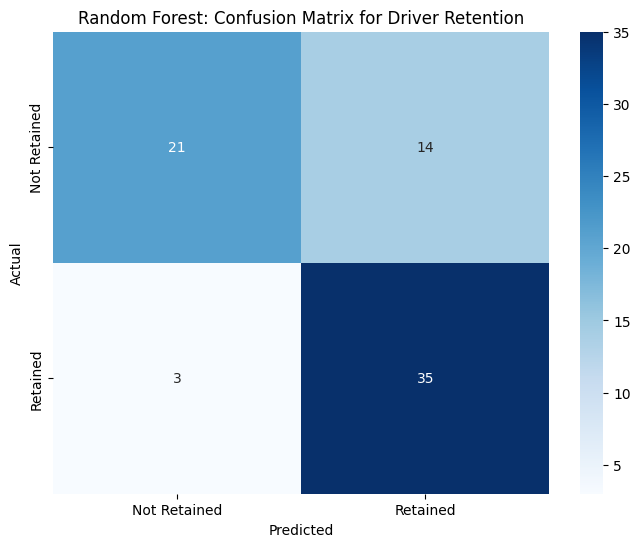

In [29]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Not Retained', 'Retained'],
            yticklabels=['Not Retained', 'Retained'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest: Confusion Matrix for Driver Retention')
plt.show()

### Decision Tree Model

In [30]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)

# Fit data
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)

# Results
print(f"Accuracy: {dt.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6712328767123288
F1: 0.6756756756756757
              precision    recall  f1-score   support

           0       0.65      0.69      0.67        35
           1       0.69      0.66      0.68        38

    accuracy                           0.67        73
   macro avg       0.67      0.67      0.67        73
weighted avg       0.67      0.67      0.67        73



### Logistic Regression Model

In [31]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=2000)

# Fit data
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Results
print(f"Accuracy: {log_reg.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.684931506849315
F1: 0.7160493827160493
              precision    recall  f1-score   support

           0       0.70      0.60      0.65        35
           1       0.67      0.76      0.72        38

    accuracy                           0.68        73
   macro avg       0.69      0.68      0.68        73
weighted avg       0.69      0.68      0.68        73



### Gradient Boosting Model

In [32]:
# Gradient Boosting
gb = GradientBoostingClassifier(random_state=42)

# Fit data
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)

# Results
print(f"Accuracy: {gb.score(X_test, y_test)}")
print(f"F1: {f1_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy: 0.6301369863013698
F1: 0.6896551724137931
              precision    recall  f1-score   support

           0       0.67      0.46      0.54        35
           1       0.61      0.79      0.69        38

    accuracy                           0.63        73
   macro avg       0.64      0.62      0.62        73
weighted avg       0.64      0.63      0.62        73



# Driver Dominance Analysis

### Load Data

In [33]:
f1_final = pd.read_csv("../data/final/f1_final.csv", encoding="utf-8")
f1_final_2010 = f1_final[f1_final["year"] >= 2010]
display(f1_final.head(3))

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular,years_experience,total_podium_finishes,total_points_finishes,dnf_rate,finish_rate,lap_completion_rate,fastest_lap_rate,podium_rate,points_rate,consistency_score,qualifying_consistency,reliability_score,qualifying_vs_race,championship_impact,race_improvement,driver_retained
0,1950,Nino Farina,Alfa Romeo,Europe,1,1.833333,0.752773,1,3,6,4.333333,4.457204,1,12,15,2.500000,30.0,5.000000,0.185185,0.030864,0.0,0.055556,282,391,3,5,0,0,0,1,False,False,False,True,1,3,5,0.166667,0.833333,0.721228,0.500000,0.500000,0.833333,-0.028586,0.589397,0.601023,2.500000,0.025720,1.363636,1
1,1950,Juan Manuel Fangio,Alfa Romeo,South America,2,2.500000,2.345208,1,7,6,6.666667,6.218253,1,13,25,4.166667,26.0,4.333333,0.160494,0.026749,0.0,0.055556,328,391,2,3,0,0,0,3,False,False,False,True,1,3,3,0.500000,0.500000,0.838875,0.333333,0.500000,0.500000,0.067262,0.061917,0.419437,4.166667,0.013374,1.666667,1
2,1950,Luigi Fagioli,Alfa Romeo,Europe,3,3.500000,1.224745,2,5,6,3.666667,3.614784,2,11,1,0.166667,28.0,4.666667,0.172840,0.028807,0.0,0.037037,291,391,0,5,0,0,0,1,False,False,False,True,1,5,5,0.166667,0.833333,0.744246,0.000000,0.833333,0.833333,0.014150,0.650073,0.620205,0.166667,0.024005,0.047619,1


### Top Drivers and Teams

Top 5 Drivers with Most Seasons:
driver
Lewis Hamilton      15
Daniel Ricciardo    14
Sergio Perez        14
Nico Hulkenberg     13
Sebastian Vettel    13
Name: year, dtype: int64

Top 3 Teams with Most Seasons:
team_name
Williams    15
McLaren     15
Ferrari     15
Name: year, dtype: int64


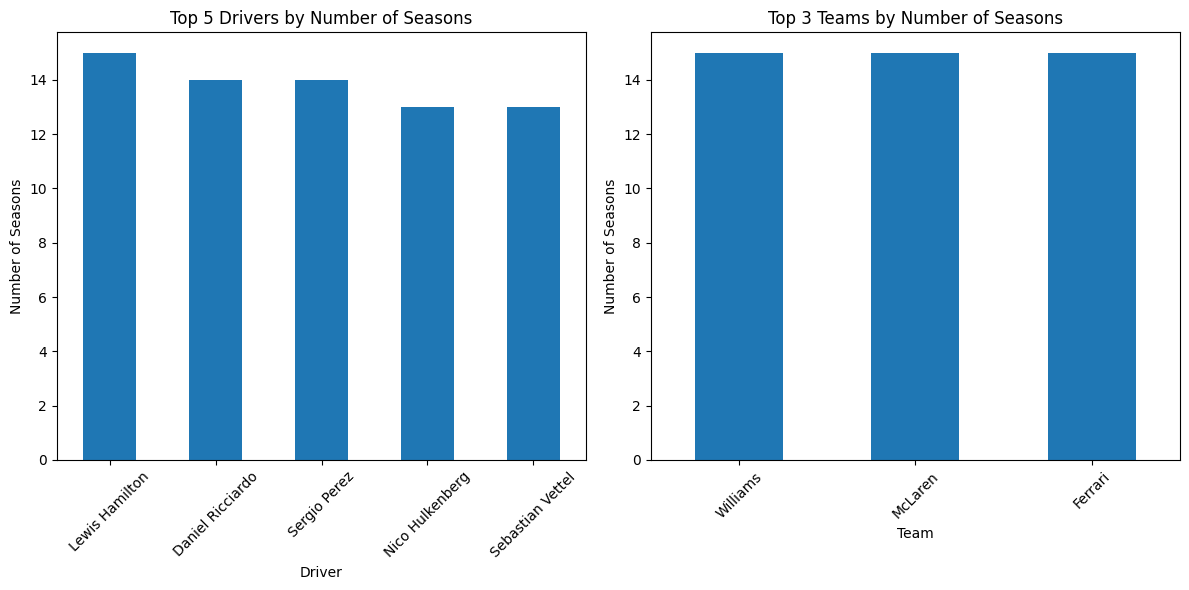

In [34]:
# Find top 5 drivers with most seasons
top_drivers = f1_final_2010.groupby("driver")["year"].nunique().sort_values(ascending=False).head(5)
print("Top 5 Drivers with Most Seasons:")
print(top_drivers)
print()

# Find top 3 teams with most seasons
top_teams = f1_final_2010.groupby("team_name")["year"].nunique().sort_values(ascending=False).head(3)
print("Top 3 Teams with Most Seasons:")
print(top_teams)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
top_drivers.plot(kind="bar")
plt.title("Top 5 Drivers by Number of Seasons")
plt.xlabel("Driver")
plt.ylabel("Number of Seasons")
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
top_teams.plot(kind="bar")
plt.title("Top 3 Teams by Number of Seasons")
plt.xlabel("Team")
plt.ylabel("Number of Seasons")
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Rankings Over Time

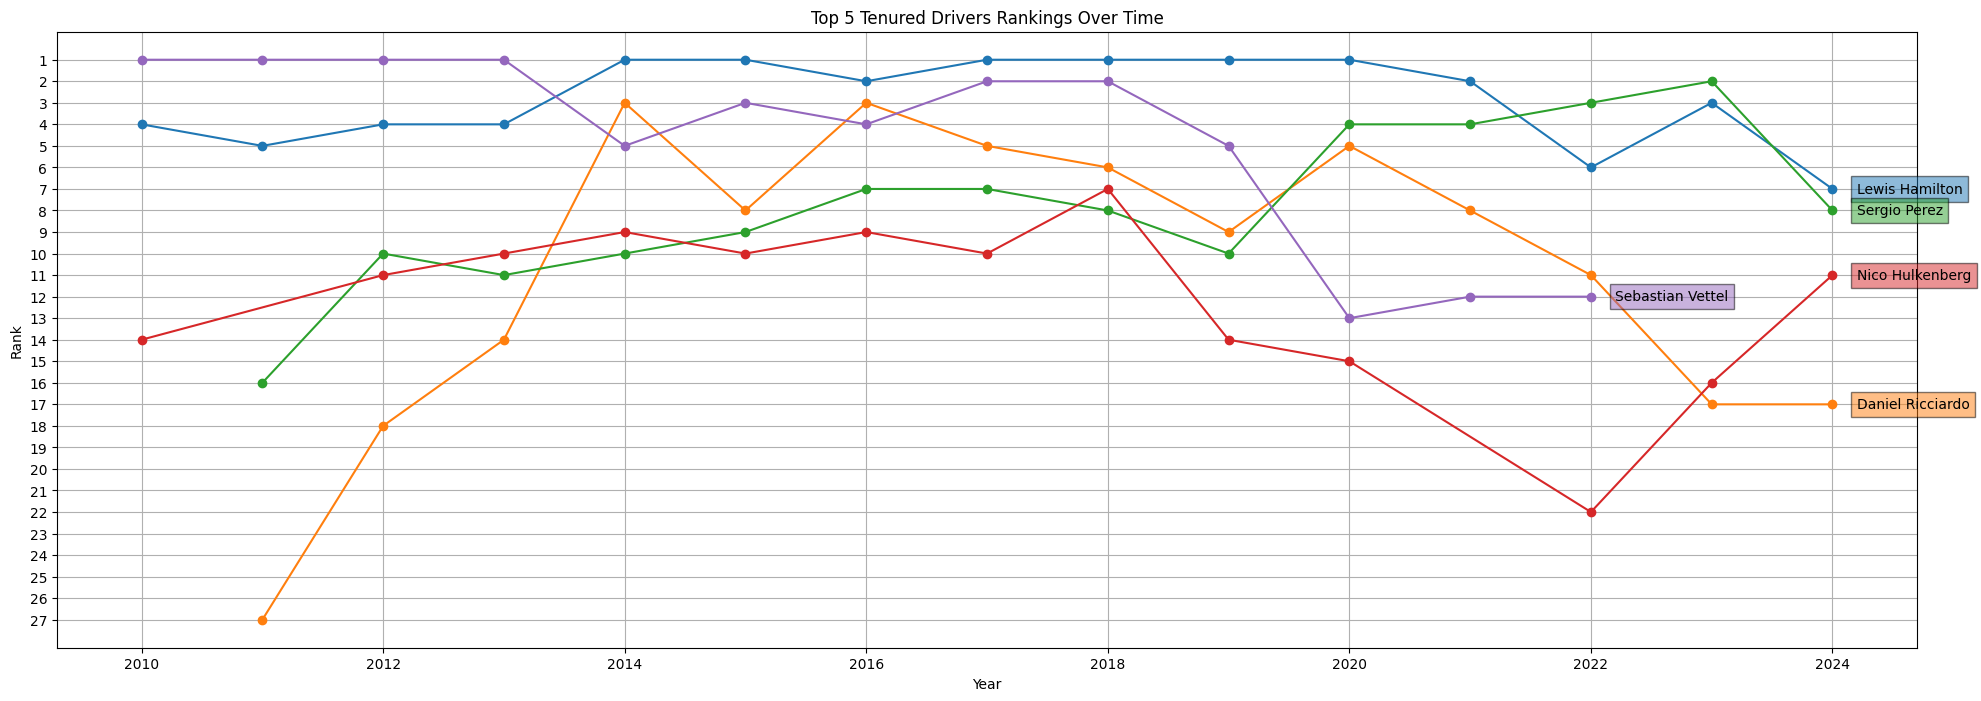

In [35]:
# Line chart of top teams rankings over time
plt.figure(figsize=(24, 8))

for driver in top_drivers.index:  # Use .index to get team names
    driver_data = f1_final_2010[f1_final_2010["driver"] == driver]
    line = plt.plot(driver_data["year"], driver_data["season_rank"], marker='o')
    # Add driver name annotation with colored box at the end of each line
    last_year = driver_data["year"].max()
    last_rank = driver_data[driver_data["year"] == last_year]["season_rank"].values[0]
    plt.text(last_year + 0.2, last_rank, driver, va='center', 
             bbox=dict(facecolor=line[0].get_color(), alpha=0.5, edgecolor='black'))

plt.gca().invert_yaxis()  # Invert y-axis so rank 1 is at the top
plt.title("Top 5 Tenured Drivers Rankings Over Time")
plt.xlabel("Year")
plt.ylabel("Rank")
plt.grid(True)
plt.yticks(range(1, 28, 1))
plt.show()

### Correlation

In [36]:
# Correlation between driver rank and time
corr, p_value = pearsonr(f1_final_2010["season_rank"], f1_final_2010["year"])

print(f"Pearson Correlation between rank and year: {corr:.3f}")
print(f"P-value: {p_value:.3f}")

if p_value < 0.05:
    print("The correlation is statistically significant (p < 0.05)")
else:
    print("The correlation is not statistically significant (p >= 0.05)")


Pearson Correlation between rank and year: -0.103
P-value: 0.051
The correlation is not statistically significant (p >= 0.05)


# Continent Analysis

### Load Data

In [37]:
f1_final = pd.read_csv("../data/final/f1_final.csv", encoding="utf-8")
f1_final_2010 = f1_final[f1_final["year"] >= 2010]
display(f1_final.head(3))

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular,years_experience,total_podium_finishes,total_points_finishes,dnf_rate,finish_rate,lap_completion_rate,fastest_lap_rate,podium_rate,points_rate,consistency_score,qualifying_consistency,reliability_score,qualifying_vs_race,championship_impact,race_improvement,driver_retained
0,1950,Nino Farina,Alfa Romeo,Europe,1,1.833333,0.752773,1,3,6,4.333333,4.457204,1,12,15,2.500000,30.0,5.000000,0.185185,0.030864,0.0,0.055556,282,391,3,5,0,0,0,1,False,False,False,True,1,3,5,0.166667,0.833333,0.721228,0.500000,0.500000,0.833333,-0.028586,0.589397,0.601023,2.500000,0.025720,1.363636,1
1,1950,Juan Manuel Fangio,Alfa Romeo,South America,2,2.500000,2.345208,1,7,6,6.666667,6.218253,1,13,25,4.166667,26.0,4.333333,0.160494,0.026749,0.0,0.055556,328,391,2,3,0,0,0,3,False,False,False,True,1,3,3,0.500000,0.500000,0.838875,0.333333,0.500000,0.500000,0.067262,0.061917,0.419437,4.166667,0.013374,1.666667,1
2,1950,Luigi Fagioli,Alfa Romeo,Europe,3,3.500000,1.224745,2,5,6,3.666667,3.614784,2,11,1,0.166667,28.0,4.666667,0.172840,0.028807,0.0,0.037037,291,391,0,5,0,0,0,1,False,False,False,True,1,5,5,0.166667,0.833333,0.744246,0.000000,0.833333,0.833333,0.014150,0.650073,0.620205,0.166667,0.024005,0.047619,1


### Distribution

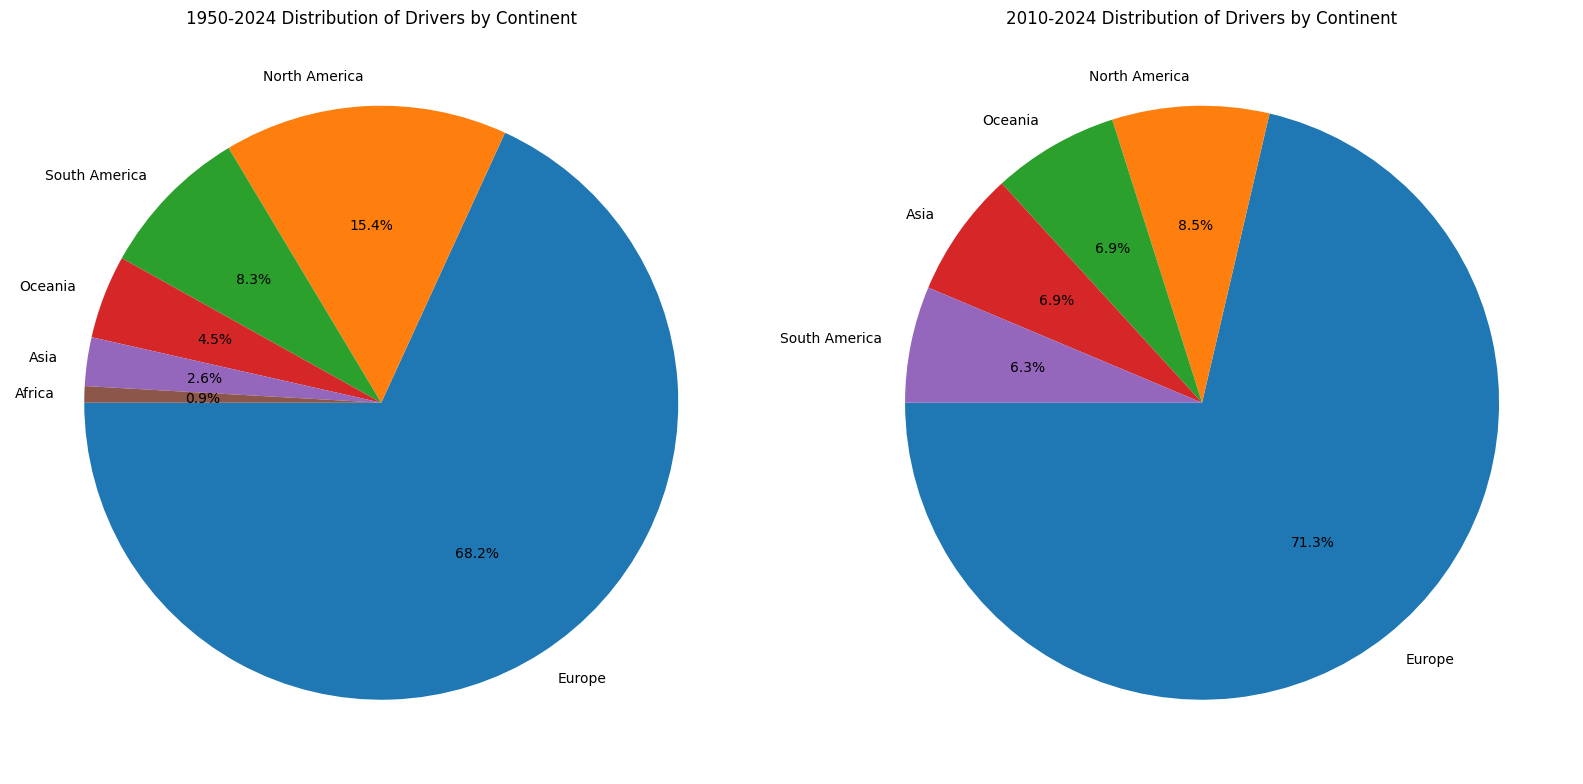

In [38]:
# Collect data
continent_counts = f1_final["continent"].value_counts()
continent_counts_2010 = f1_final_2010["continent"].value_counts()

# Plot continent distribution
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pie(continent_counts, labels=continent_counts.index, autopct="%1.1f%%", startangle=180)
plt.title("1950-2024 Distribution of Drivers by Continent")

plt.subplot(1, 2, 2)
plt.pie(continent_counts_2010, labels=continent_counts_2010.index, autopct="%1.1f%%", startangle=180)
plt.title("2010-2024 Distribution of Drivers by Continent")

plt.tight_layout()
plt.show()

### Count

C:\Users\jackw\AppData\Local\Temp\ipykernel_9668\2840708997.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(continent_counts.index)
C:\Users\jackw\AppData\Local\Temp\ipykernel_9668\2840708997.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(continent_counts_2010.index)


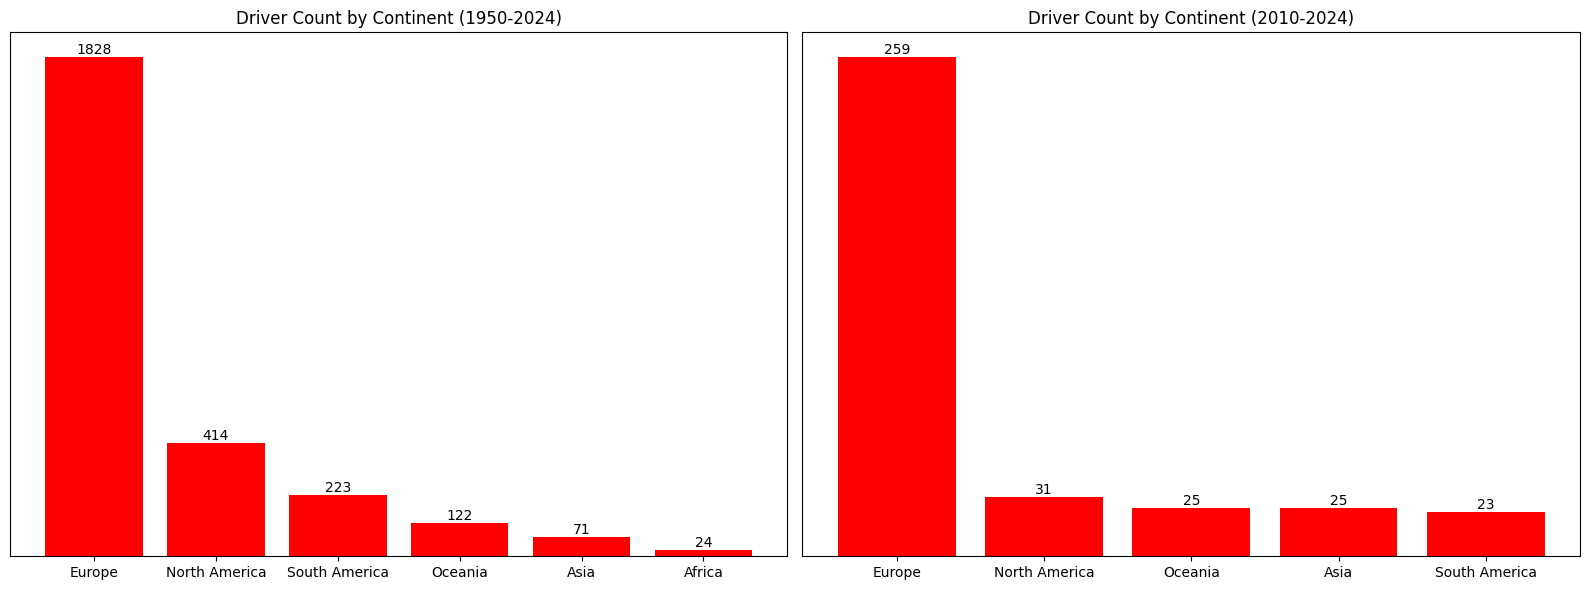

In [39]:
# Create figure and axes for bar charts
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart for 1950-2024
ax = axs[0]
bars = ax.bar(continent_counts.index, continent_counts.values, color='red')
ax.set_title("Driver Count by Continent (1950-2024)")
ax.set_xticklabels(continent_counts.index)
ax.bar_label(bars, fmt="%.0f")
ax.set_yticks([])

# Bar chart for 2010-2024 
ax = axs[1]
bars = ax.bar(continent_counts_2010.index, continent_counts_2010.values, color='red')
ax.set_title("Driver Count by Continent (2010-2024)")
ax.set_xticklabels(continent_counts_2010.index)
ax.bar_label(bars, fmt="%.0f")
ax.set_yticks([])

plt.tight_layout()
plt.show()

### Performance

C:\Users\jackw\AppData\Local\Temp\ipykernel_9668\3739838588.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(continent_avg.index)
C:\Users\jackw\AppData\Local\Temp\ipykernel_9668\3739838588.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(continent_avg_2010.index)
C:\Users\jackw\AppData\Local\Temp\ipykernel_9668\3739838588.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(continent_avg.index)
C:\Users\jackw\AppData\Local\Temp\ipykernel_9668\3739838588.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(continent_avg_2010.index)


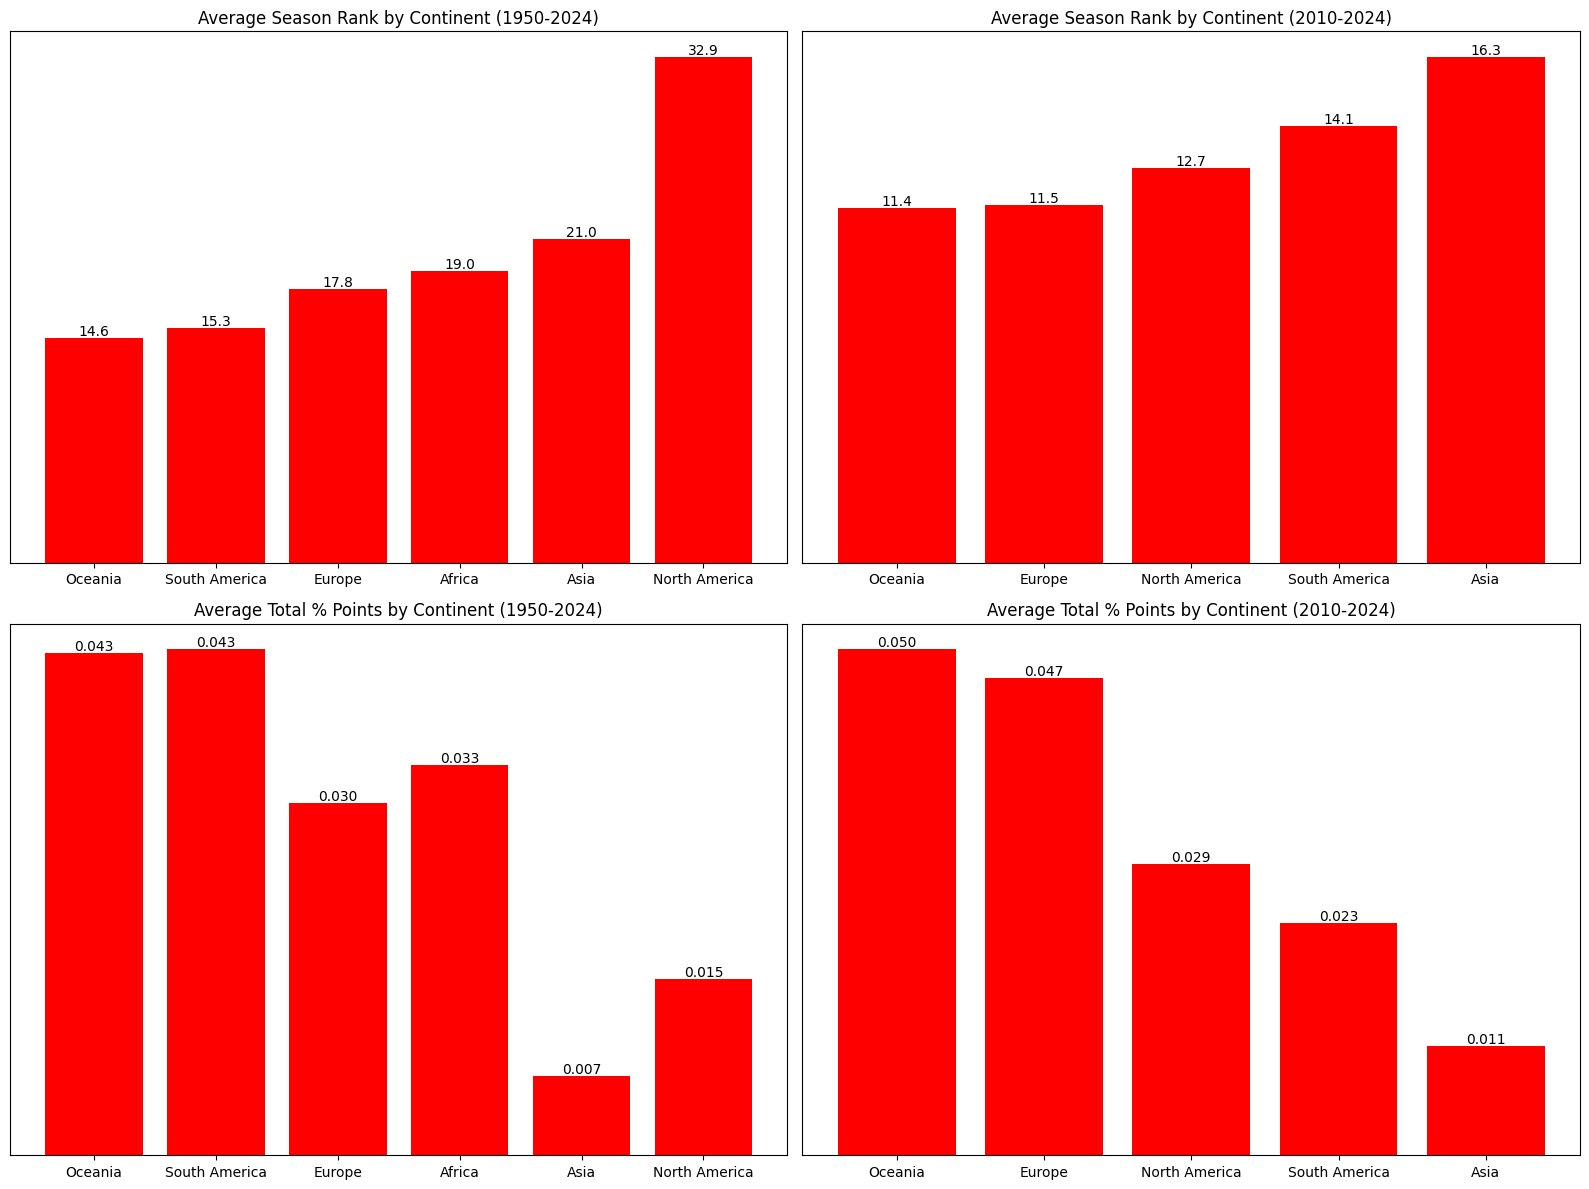

In [40]:
# Calculate average metrics by continent
continent_avg = f1_final.groupby("continent")[["season_rank", "total_pct_season_points"]].mean().sort_values("season_rank")
continent_avg_2010 = f1_final_2010.groupby("continent")[["season_rank", "total_pct_season_points"]].mean().sort_values("season_rank")

# Create figure and axes
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Avg Season Rank (1950–2024)
ax = axs[0, 0]
bars = ax.bar(continent_avg.index, continent_avg["season_rank"], color="red")
ax.set_title("Average Season Rank by Continent (1950-2024)")
ax.set_xticklabels(continent_avg.index)
ax.bar_label(bars, fmt="%.1f")
ax.set_yticks([])

# Avg Season Rank (2010–2024)
ax = axs[0, 1]
bars = ax.bar(continent_avg_2010.index, continent_avg_2010["season_rank"], color="red")
ax.set_title("Average Season Rank by Continent (2010-2024)")
ax.set_xticklabels(continent_avg_2010.index)
ax.bar_label(bars, fmt="%.1f")
ax.set_yticks([])

# Avg % Points (1950–2024)
ax = axs[1, 0]
bars = ax.bar(continent_avg.index, continent_avg["total_pct_season_points"], color="red")
ax.set_title("Average Total % Points by Continent (1950-2024)")
ax.set_xticklabels(continent_avg.index)
ax.bar_label(bars, fmt="%.3f")
ax.set_yticks([])

# Avg % Points (2010–2024)
ax = axs[1, 1]
bars = ax.bar(continent_avg_2010.index, continent_avg_2010["total_pct_season_points"], color="red")
ax.set_title("Average Total % Points by Continent (2010-2024)")
ax.set_xticklabels(continent_avg_2010.index)
ax.bar_label(bars, fmt="%.3f")
ax.set_yticks([])

plt.tight_layout()
plt.show()


# Age Analysis

### Load Data

In [42]:
f1_final = pd.read_csv("../data/final/f1_final.csv", encoding="utf-8")
f1_final_2010 = f1_final[f1_final["year"] >= 2010]
display(f1_final.head(3))

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular,years_experience,total_podium_finishes,total_points_finishes,dnf_rate,finish_rate,lap_completion_rate,fastest_lap_rate,podium_rate,points_rate,consistency_score,qualifying_consistency,reliability_score,qualifying_vs_race,championship_impact,race_improvement,driver_retained
0,1950,Nino Farina,Alfa Romeo,Europe,1,1.833333,0.752773,1,3,6,4.333333,4.457204,1,12,15,2.500000,30.0,5.000000,0.185185,0.030864,0.0,0.055556,282,391,3,5,0,0,0,1,False,False,False,True,1,3,5,0.166667,0.833333,0.721228,0.500000,0.500000,0.833333,-0.028586,0.589397,0.601023,2.500000,0.025720,1.363636,1
1,1950,Juan Manuel Fangio,Alfa Romeo,South America,2,2.500000,2.345208,1,7,6,6.666667,6.218253,1,13,25,4.166667,26.0,4.333333,0.160494,0.026749,0.0,0.055556,328,391,2,3,0,0,0,3,False,False,False,True,1,3,3,0.500000,0.500000,0.838875,0.333333,0.500000,0.500000,0.067262,0.061917,0.419437,4.166667,0.013374,1.666667,1
2,1950,Luigi Fagioli,Alfa Romeo,Europe,3,3.500000,1.224745,2,5,6,3.666667,3.614784,2,11,1,0.166667,28.0,4.666667,0.172840,0.028807,0.0,0.037037,291,391,0,5,0,0,0,1,False,False,False,True,1,5,5,0.166667,0.833333,0.744246,0.000000,0.833333,0.833333,0.014150,0.650073,0.620205,0.166667,0.024005,0.047619,1


### Performance

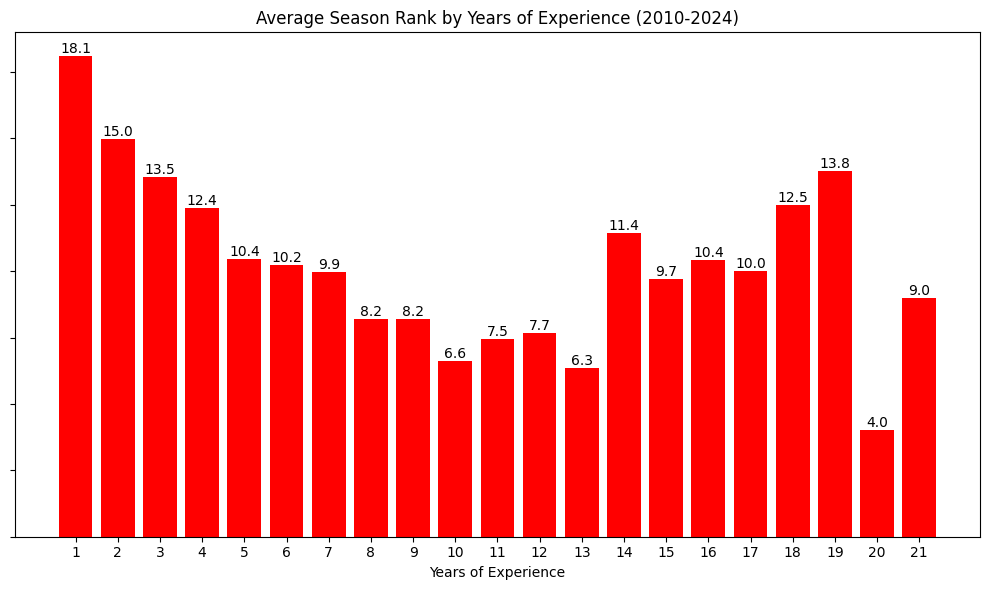

In [43]:
# Calculate average season rank by years of experience
exp_avg = f1_final_2010.groupby("years_experience")["season_rank"].mean().reset_index()

# Plot using fig and ax for better control
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(exp_avg["years_experience"], exp_avg["season_rank"], color='red')
ax.set_title("Average Season Rank by Years of Experience (2010-2024)")
ax.set_xlabel("Years of Experience")
ax.set_xticks(exp_avg["years_experience"])
ax.set_xticklabels(exp_avg["years_experience"])
ax.bar_label(bars, fmt="%.1f")
ax.set_yticklabels([])

plt.tight_layout()
plt.show()


### Correlation

Pearson correlation (experience vs rank): -0.378, p-value: 0.000
The correlation is statistically significant (p < 0.05)
Pearson correlation (experience vs points): 0.326, p-value: 0.000
The correlation is statistically significant (p < 0.05)


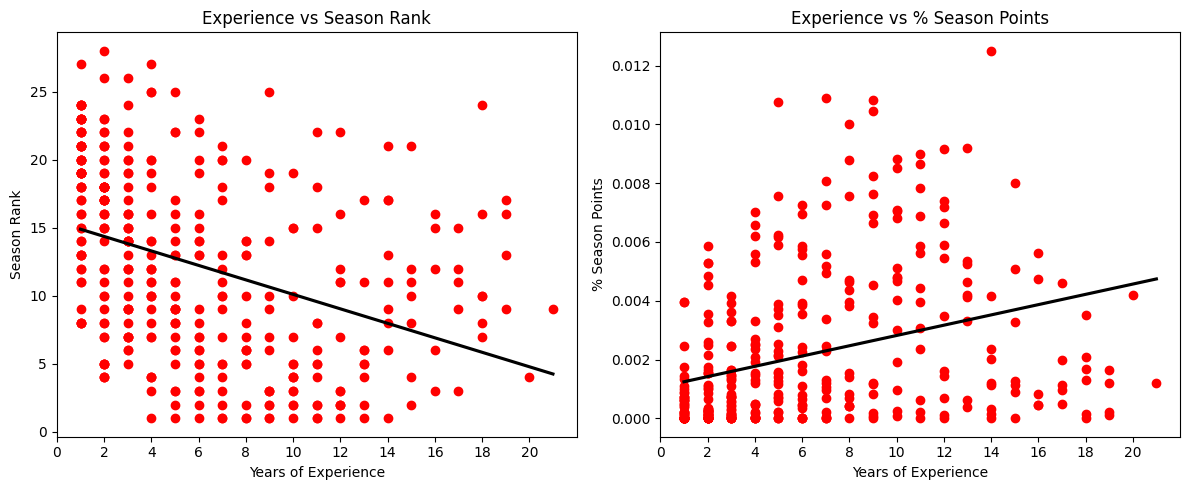

In [44]:
# Correlation between years of experience and season rank
corr_rank, p_rank = pearsonr(f1_final_2010["years_experience"], f1_final_2010["season_rank"])
print(f"Pearson correlation (experience vs rank): {corr_rank:.3f}, p-value: {p_rank:.3f}")

if p_rank < 0.05:
    print("The correlation is statistically significant (p < 0.05)")
else:
    print("The correlation is not statistically significant (p >= 0.05)")

# Correlation between years of experience and pct season points
corr_points, p_points = pearsonr(f1_final_2010["years_experience"], f1_final_2010["avg_pct_season_points"])
print(f"Pearson correlation (experience vs points): {corr_points:.3f}, p-value: {p_points:.3f}")

if p_points < 0.05:
    print("The correlation is statistically significant (p < 0.05)")
else:
    print("The correlation is not statistically significant (p >= 0.05)")

# Plot relationships with trend lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First plot with trend line
ax1.scatter(f1_final_2010["years_experience"], f1_final_2010["season_rank"], color="red")
sns.regplot(x=f1_final_2010["years_experience"], y=f1_final_2010["season_rank"], scatter=False, color='black', ax=ax1, ci=None)
ax1.set_title("Experience vs Season Rank")
ax1.set_xlabel("Years of Experience")
ax1.set_ylabel("Season Rank")
ax1.set_xticks(range(0, int(f1_final_2010["years_experience"].max())+1, 2))

# Second plot with trend line
ax2.scatter(f1_final_2010["years_experience"], f1_final_2010["avg_pct_season_points"], color="red")
sns.regplot(x=f1_final_2010["years_experience"], y=f1_final_2010["avg_pct_season_points"], scatter=False, color='black', ax=ax2, ci=None)
ax2.set_title("Experience vs % Season Points")
ax2.set_xlabel("Years of Experience")
ax2.set_ylabel("% Season Points")
ax2.set_xticks(range(0, int(f1_final_2010["years_experience"].max())+1, 2))

plt.tight_layout()
plt.show()


# Total Points Analysis (2010-2024)

*Linear Regression the best model with accuracy of 0.9639, MSE of 433.2298, and R2 of 0.9639*

### Load Data

In [60]:
f1_final = pd.read_csv("../data/final/f1_final.csv", encoding="utf-8")
f1_final_2010 = f1_final[f1_final["year"] >= 2010]
f1_final_2010.head(3)

,year,driver,team_name,continent,season_rank,avg_start_pos,std_start_pos,best_start_pos,worst_start_pos,races_participated,avg_finish_pos,std_finish_pos,best_finish_pos,worst_finish_pos,total_pos_gain,avg_pos_gain,total_points,avg_points_per_race,total_pct_season_points,avg_pct_season_points,worst_pct_season_points,best_pct_season_points,total_laps_completed,total_laps,total_fastest_laps,CLAS_total,DNF_total,DNS_total,DQ_total,NC_total,backmarker,midfield,podium_regular,points_regular,years_experience,total_podium_finishes,total_points_finishes,dnf_rate,finish_rate,lap_completion_rate,fastest_lap_rate,podium_rate,points_rate,consistency_score,qualifying_consistency,reliability_score,qualifying_vs_race,championship_impact,race_improvement,driver_retained
3146,2010,Sebastian Vettel,Red Bull,Europe,1,1.947368,1.352926,1,6,19,6.000000,6.565905,1,22,77,4.052632,256.0,13.473684,0.133403,0.007021,0.0,0.013028,1066,1129,3,16,0,0,0,3,False,False,False,True,4,10,15,0.157895,0.842105,0.944198,0.157895,0.526316,0.789474,-0.094318,0.305254,0.795114,4.052632,0.005913,2.081081,1
3147,2010,Fernando Alonso,Ferrari,Europe,2,5.789474,6.214490,1,24,19,5.421053,5.439728,1,21,-7,-0.368421,252.0,13.263158,0.131318,0.006911,0.0,0.013028,1120,1129,5,18,0,0,0,1,False,False,False,True,9,10,16,0.052632,0.947368,0.992028,0.263158,0.526316,0.842105,-0.003445,-0.073412,0.939816,-0.368421,0.006548,-0.063636,1
3148,2010,Mark Webber,Red Bull,Oceania,3,2.789474,1.843274,1,7,19,6.052632,6.736911,1,24,62,3.263158,242.0,12.736842,0.126107,0.006637,0.0,0.013028,1043,1129,3,17,0,0,0,2,False,False,False,True,9,10,17,0.105263,0.894737,0.923826,0.157895,0.526316,0.894737,-0.113055,0.339203,0.826582,3.263158,0.005939,1.169811,1


### Split Data

In [61]:
# Set X and y variables
X = f1_final_2010.drop(columns=["driver_retained", "year", "driver", "team_name", "continent", "total_laps_completed", "total_laps", "total_points", 
                                "podium_regular", "points_regular", "midfield", "backmarker", 
                                "total_podium_finishes", "total_points_finishes", "podium_rate", "points_rate",
                                "total_pct_season_points", "avg_pct_season_points", "best_pct_season_points", "worst_pct_season_points", "avg_points_per_race", 
                                "championship_impact", "season_rank"])
y = f1_final_2010["total_points"].values

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Linear Regression Model

In [62]:
# Linear Regression
lin_reg = LinearRegression()

# Fit data
lin_reg.fit(X_train, y_train)
y_pred = lin_reg.predict(X_test)
predictions = lin_reg.predict(X)

# Results
print(f"Accuracy: {lin_reg.score(X_test, y_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

Accuracy: 0.9639154925868509
MSE: 433.2298646968063
R2: 0.9639154925868509


In [63]:
# Get feature importance
importance = pd.DataFrame({"feature": X.columns, "importance": lin_reg.coef_}).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print(importance.head(10))


Top 10 Most Important Features:
               feature  importance
21    fastest_lap_rate   67.464894
13           DNF_total   10.258617
19         finish_rate    7.199035
4   races_participated    1.938364
11  total_fastest_laps    1.906758
2       best_start_pos    1.266859
7      best_finish_pos    1.106087
12          CLAS_total    0.862697
17    years_experience    0.571419
3      worst_start_pos    0.522987


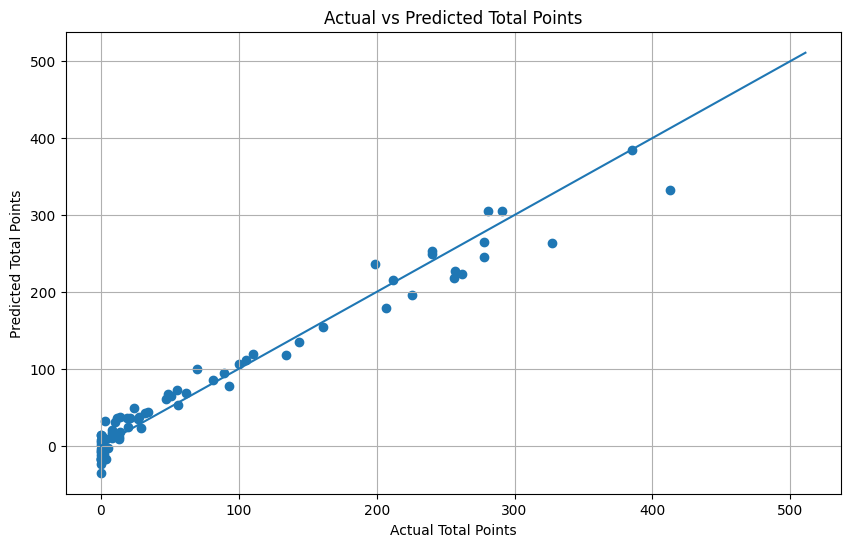

In [64]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs Predicted Total Points")
plt.grid(True)
plt.show()

### Ridge Regression

In [65]:
# Ridge Regression
ridge_reg = Ridge()

# Fit data
ridge_reg.fit(X_train, y_train)
y_pred_ridge = ridge_reg.predict(X_test)
predictions_ridge = ridge_reg.predict(X)

# Results
print(f"Accuracy: {ridge_reg.score(X_test, y_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_ridge)}")
print(f"R2: {r2_score(y_test, y_pred_ridge)}")

Accuracy: 0.9559446788593183
MSE: 528.927292769334
R2: 0.9559446788593183


In [66]:
# Get feature importance
importance = pd.DataFrame({"feature": X.columns, "importance": ridge_reg.coef_}).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print(importance.head(10))


Top 10 Most Important Features:
               feature  importance
11  total_fastest_laps    9.266646
13           DNF_total    6.137200
18            dnf_rate    4.597738
2       best_start_pos    2.496344
12          CLAS_total    2.270015
7      best_finish_pos    2.213280
16            NC_total    1.102031
3      worst_start_pos    0.984775
4   races_participated    0.610565
17    years_experience    0.552321


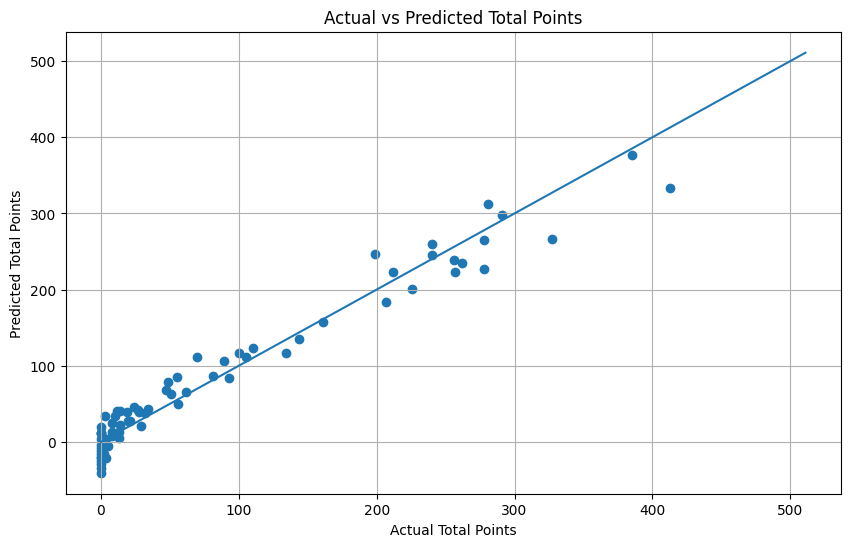

In [67]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ridge)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs Predicted Total Points")
plt.grid(True)
plt.show()

### Lasso Regression

In [68]:
# Lasso Regression
lasso_reg = Lasso()

# Fit data
lasso_reg.fit(X_train, y_train)
y_pred_lasso = lasso_reg.predict(X_test)
predictions_lasso = lasso_reg.predict(X)

# Results
print(f"Accuracy: {lasso_reg.score(X_test, y_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_lasso)}")
print(f"R2: {r2_score(y_test, y_pred_lasso)}")

Accuracy: 0.9361656354607029
MSE: 766.3940869617908
R2: 0.9361656354607029


In [69]:
# Get feature importance
importance = pd.DataFrame({"feature": X.columns, "importance": lasso_reg.coef_}).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print(importance.head(10))


Top 10 Most Important Features:
               feature  importance
11  total_fastest_laps   14.508840
2       best_start_pos    4.833729
7      best_finish_pos    3.381535
4   races_participated    2.688845
3      worst_start_pos    1.197384
17    years_experience    0.511719
12          CLAS_total    0.225810
9       total_pos_gain    0.117568
13           DNF_total    0.000000
16            NC_total    0.000000


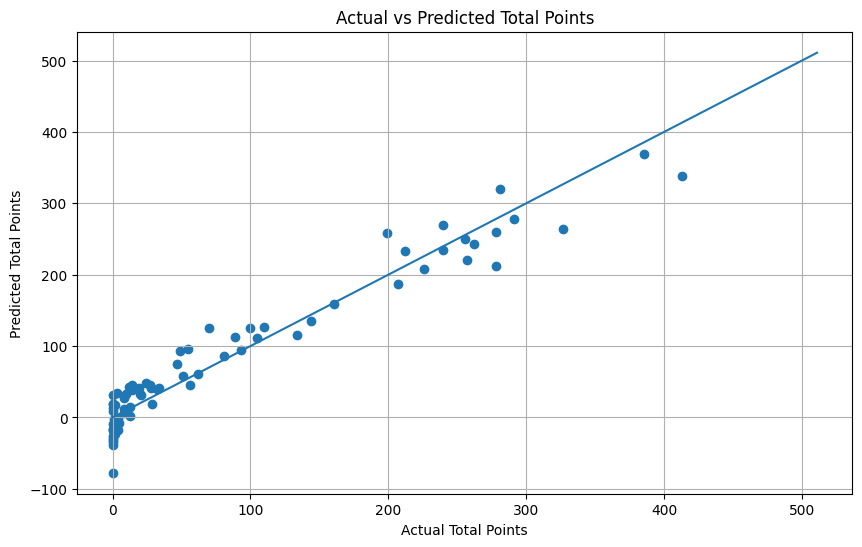

In [70]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_lasso)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs Predicted Total Points")
plt.grid(True)
plt.show()

### Decision Tree Regressor

In [71]:
# Decision Tree Regression
dt = DecisionTreeRegressor()

# Fit data
dt.fit(X_train, y_train)
y_pred_tree = dt.predict(X_test)
predictions_tree = dt.predict(X)

# Results
print(f"Accuracy: {dt.score(X_test, y_test)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_tree)}")
print(f"R2: {r2_score(y_test, y_pred_tree)}")

Accuracy: 0.9528291564411842
MSE: 566.332191780822
R2: 0.9528291564411842


In [72]:
# Get feature importance
importance = pd.DataFrame({"feature": X.columns, "importance": dt.feature_importances_}).sort_values("importance", ascending=False)

print("\nTop 10 Most Important Features:")
print(importance.head(10))


Top 10 Most Important Features:
                   feature  importance
22       consistency_score    0.744300
5           avg_finish_pos    0.212102
7          best_finish_pos    0.020127
23  qualifying_consistency    0.006247
0            avg_start_pos    0.004435
11      total_fastest_laps    0.003851
1            std_start_pos    0.001723
12              CLAS_total    0.001574
19             finish_rate    0.001505
18                dnf_rate    0.000910


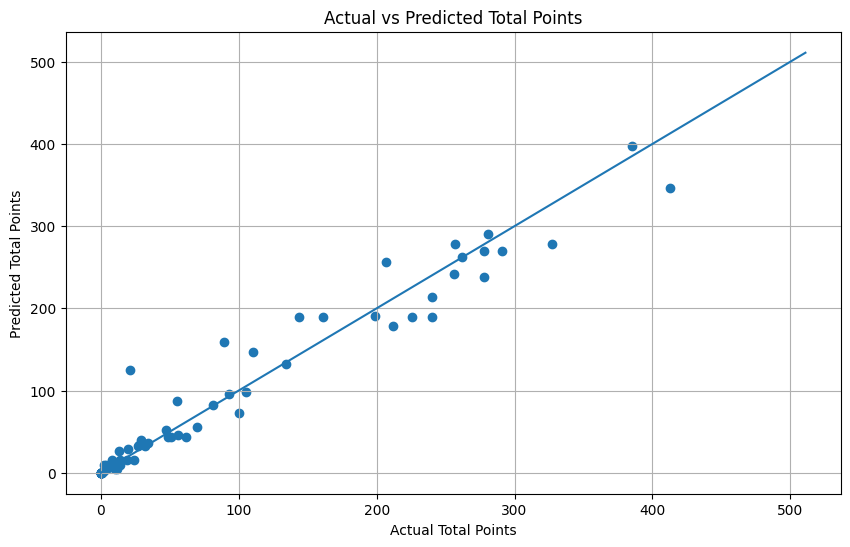

In [73]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_tree)
plt.plot([y.min(), y.max()], [y.min(), y.max()])
plt.xlabel("Actual Total Points")
plt.ylabel("Predicted Total Points")
plt.title("Actual vs Predicted Total Points")
plt.grid(True)
plt.show()